# 데이터 로드 및 확인
1. 아래의 데이터는 2009 ~ 2016간 10분단위로 날씨에 관한 각종 정보를 기록한 것이다.
2. 우리는 이 데이터들을 활용하여 RNN 모델을 학습시키고, 측정값이 주어졌을 때 24시간 뒤의 온도를 예측하는 모델을 구성할 것이다


In [39]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-09-14 03:37:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.21.176, 52.217.32.6, 52.217.229.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.21.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  9.89MB/s    in 1.3s    

2023-09-14 03:37:44 (9.89 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [40]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [41]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

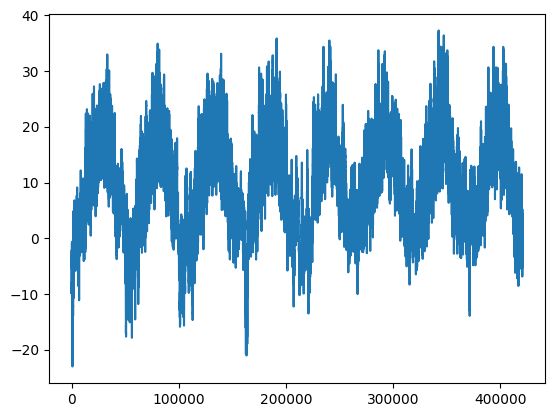

In [42]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(lines)), temperature)
plt.show()

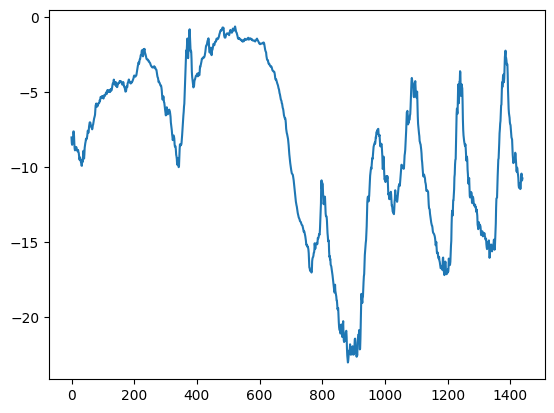

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.show()

# 데이터 전처리 및 분할

In [43]:
num_train_samples = int(len(lines) * 0.5)
num_val_samples = int(len(lines) * 0.25)
num_test_samples = len(lines) - num_train_samples - num_val_samples
print(f"훈련 데이터 갯수 : {num_train_samples}")
print(f"검증 데이터 갯수 : {num_val_samples}")
print(f"테스트 데이터 갯수 : {num_test_samples}")

훈련 데이터 갯수 : 210225
검증 데이터 갯수 : 105112
테스트 데이터 갯수 : 105114


In [44]:
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

print(raw_data.shape)

(420451, 14)


In [56]:
from tensorflow import keras
import tensorflow as tf

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = 120,
    shuffle=True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle=True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

In [57]:
train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, [None, 120, 14]), tf.ensure_shape(y, [None])))
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 120, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# 기본적인 방법 사용해보기(Conv1D, Dense layer)

In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

evaluate_naive_method(train_dataset)

2.691643827770379

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x", save_best_only = True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks
                    )

Epoch 1/10
819/819 [==============================] - 51s 60ms/step - loss: 15.6257 - mae: 3.0301 - val_loss: 10.5190 - val_mae: 2.5524
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 9.9219 - mae: 2.4838 - val_loss: 10.1937 - val_mae: 2.5094
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 9.1027 - mae: 2.3747 - val_loss: 10.4564 - val_mae: 2.5363
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 8.5841 - mae: 2.3047 - val_loss: 10.2417 - val_mae: 2.5170
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 8.2359 - mae: 2.2568 - val_loss: 12.3888 - val_mae: 2.7678
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 7.9655 - mae: 2.2195 - val_loss: 12.3775 - val_mae: 2.7857
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 7.7308 - mae: 2.1892 - val_loss: 14.0596 - val_mae: 2.9923
Epoch 8/10
819/819 [==============================] - 

OSError: ignored

405/405 [==============================] - 21s 50ms/step - loss: 10.9716 - mae: 2.6079
테스트 MAE : 2.61


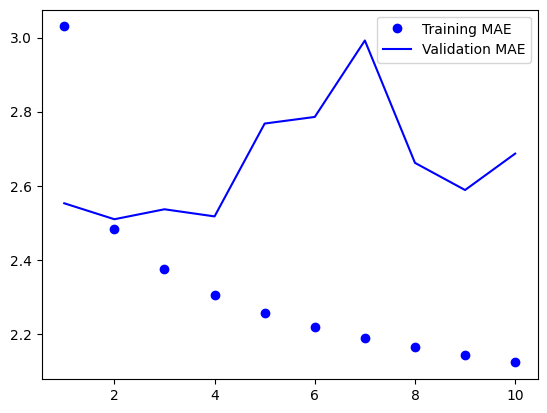

In [ ]:
import matplotlib.pyplot as plt

model = keras.models.load_model("jena_dense.x")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.x",
                                    save_best_only = True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model("jena_conv.x")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 99ms/step - loss: 26.1594 - mae: 3.9833 - val_loss: 19.2885 - val_mae: 3.4682
Epoch 2/10
819/819 [==============================] - 86s 105ms/step - loss: 19.5339 - mae: 3.5211 - val_loss: 18.7886 - val_mae: 3.4606
Epoch 3/10
819/819 [==============================] - 82s 99ms/step - loss: 18.6602 - mae: 3.4417 - val_loss: 20.4670 - val_mae: 3.5767
Epoch 4/10
819/819 [==============================] - 93s 113ms/step - loss: 18.0470 - mae: 3.3845 - val_loss: 21.1346 - val_mae: 3.6118
Epoch 5/10
819/819 [==============================] - 87s 106ms/step - loss: 17.5643 - mae: 3.3380 - val_loss: 20.5115 - val_mae: 3.5590
Epoch 6/10
819/819 [==============================] - 90s 109ms/step - loss: 17.1742 - mae: 3.2997 - val_loss: 19.8699 - val_mae: 3.5772
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 16.8690 - mae: 3.2710 - val_loss: 19.8142 - val_mae: 3.5754
Epoch 8/10
819/819 [=======================

# LSTM 활용해보기

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 36ms/step - loss: 10.9605 - mae: 2.5902
테스트 MAE : 2.59


# RNN 이해해보기
- 아래와 같은 과정을 실제로 keras의 SimpleRNN 층에서 실행해준다

In [ ]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
hidden_state = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []

for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, hidden_state) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

print(final_output_sequence.shape)

(100, 64)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # unrolling( RNN의 for 루프를 for루프 없이 N번 기술하여 keras가 계산 그래프를 만들기 쉽게 해줌) -> 메모리가 많이 들어 작은 시퀀스에 대해, 타입스텝이 고정된 경우에만 사용
x = layers.Dropout(0.5)(x) # Dense 층에 대한 규제이다
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x", save_best_only = True)
]

model.compile(optimizer="rmsprop", loss = "mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 222s 262ms/step - loss: 27.6761 - mae: 3.8835 - val_loss: 9.9752 - val_mae: 2.4397
Epoch 2/20
819/819 [==============================] - 216s 263ms/step - loss: 14.6857 - mae: 2.9773 - val_loss: 9.4042 - val_mae: 2.3814
Epoch 3/20
819/819 [==============================] - 202s 247ms/step - loss: 13.7138 - mae: 2.8771 - val_loss: 9.3725 - val_mae: 2.3774
Epoch 4/20
819/819 [==============================] - 216s 263ms/step - loss: 13.1683 - mae: 2.8161 - val_loss: 9.3105 - val_mae: 2.3711
Epoch 5/20
819/819 [==============================] - 202s 247ms/step - loss: 12.6530 - mae: 2.7607 - val_loss: 9.1632 - val_mae: 2.3572
Epoch 6/20
819/819 [==============================] - 201s 245ms/step - loss: 12.3073 - mae: 2.7217 - val_loss: 9.5804 - val_mae: 2.4135
Epoch 7/20
819/819 [==============================] - 213s 260ms/step - loss: 11.9513 - mae: 2.6830 - val_loss: 9.6085 - val_mae: 2.4079
Epoch 8/20
819/819 [=====================

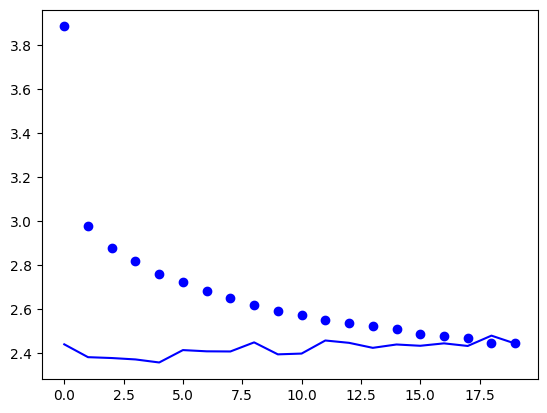

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.show()

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True, unroll=True)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


In [60]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 120, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [61]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - ETA: 0s - loss: 80.0418 - mae: 7.2391

ValueError: ignored